# Import modules

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.kernel_ridge import KernelRidge

from scipy.linalg import hadamard
from scipy.stats import cauchy

from tqdm.notebook import tqdm

from bisect import bisect

from kernels import rbf_kernel
from loess import *


# Generate one-dimensional synthetic data

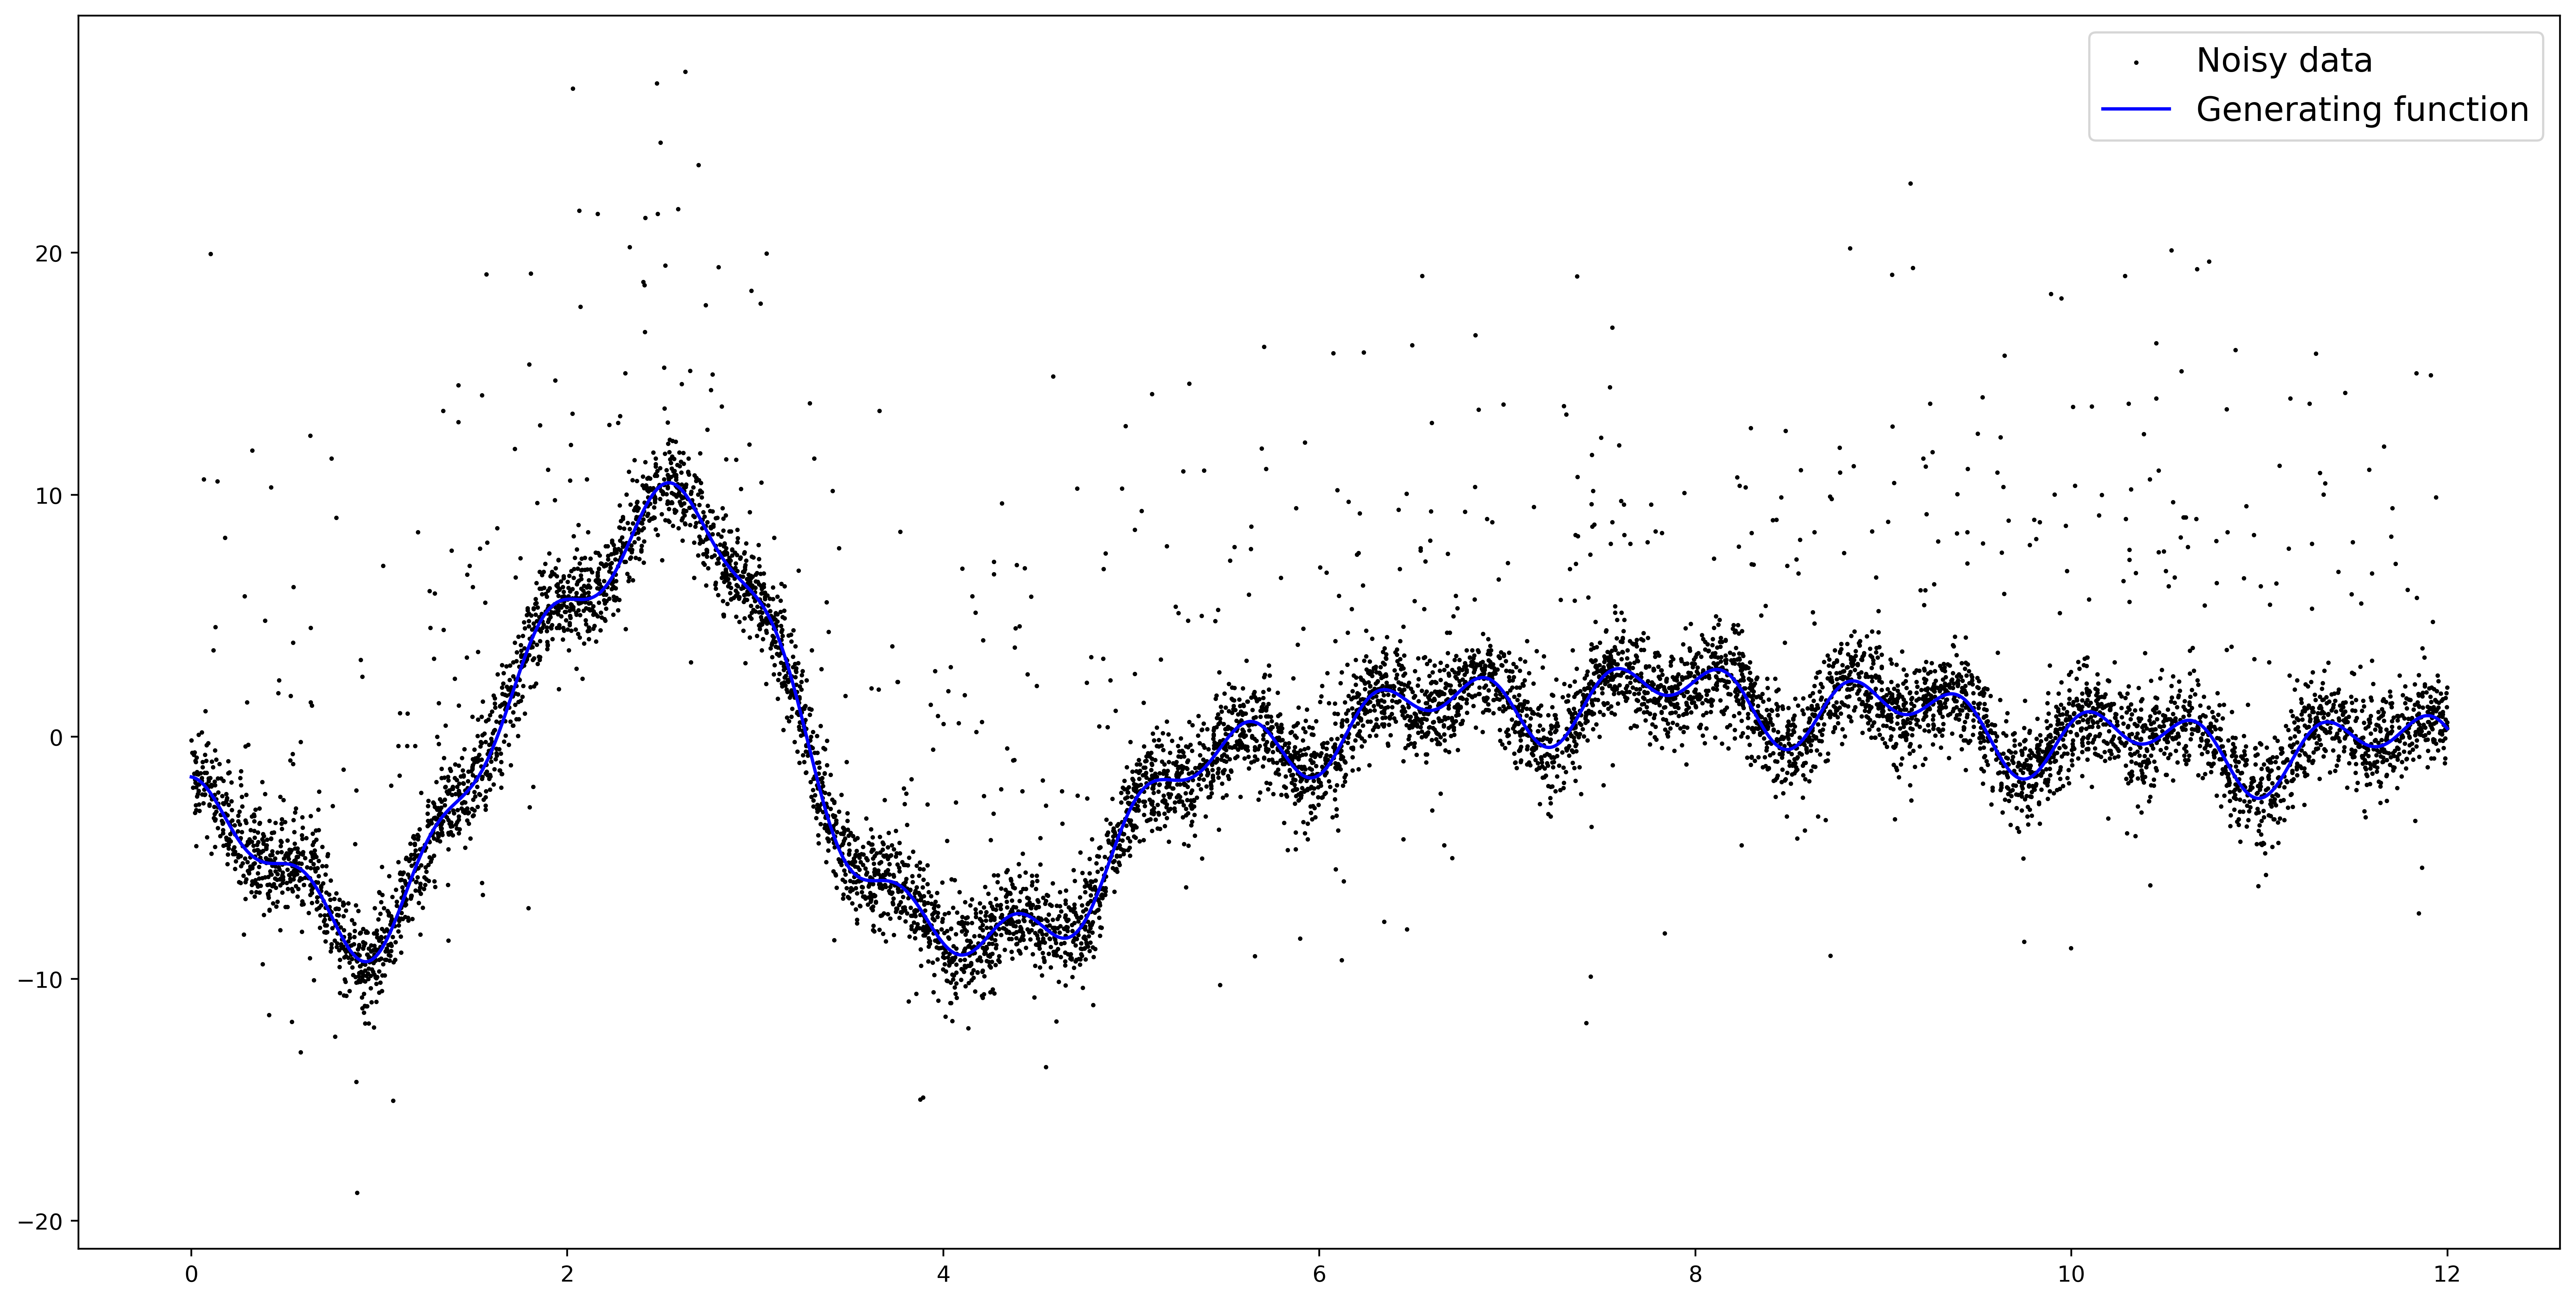

In [5]:
n = 2**13

x = np.random.uniform(0, 12, n)
#x = np.random.uniform(0, 10, n).reshape(-1, 1)
#x = np.vstack((x, np.random.uniform(0, 10, n).reshape(-1, 1))).reshape(-1)

# Generate outliers via chance of greater sd on normal errors
def gen_outlier_eps(inlier_dist, outlier_dist, outlier_prop, n):
    eps = np.zeros(n)
    for i in range(n):
        u = np.random.uniform(0, 1)
        if u < outlier_prop:
            eps[i] = outlier_dist(1)
        else:
            eps[i] = inlier_dist(1)
    return eps
eps = gen_outlier_eps(lambda n: np.random.normal(0, 1, n),
                      lambda n: np.random.normal(0, 6, n) + 5,
                      0.1, x.shape[0])

generating = np.sin(x) + np.sin(5*x) + np.cos(1/10 * x) + 10*np.exp(- (x - 2.5)**2 ) - 10*np.exp(- (x - 4)**2 ) - 10*np.exp(- (x - 1)**2 ) + np.cos(10*x)
#generating = 10*x

y = generating + eps

plt.figure(figsize = (20, 10), dpi = 400)
plt.scatter(x, y, s = 1, color = 'black', label = 'Noisy data', alpha = 1)
out = np.hstack((x.reshape(-1, 1), generating.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'blue', label = 'Generating function')
plt.legend(fontsize = 15)
plt.show()

In [6]:
( ( y - generating ) **2 ).mean()

6.888231059000706

## Compare LOESS, kernel and poylnomial regression

In [7]:
y_hat0 = fit_loess(x, y, anchors = None, degree = 0, kernel = rbf_kernel, alpha = 0.15, frac = None, robust_iters = 2)
y_hat1 = fit_loess(x, y, anchors = None, degree = 1, kernel = rbf_kernel, alpha = 0.15, frac = None, robust_iters = 2)
y_hat2 = fit_loess(x, y, anchors = None, degree = 2, kernel = rbf_kernel, alpha = 0.15, frac = None, robust_iters = 2)
y_hat3 = fit_loess(x, y, anchors = None, degree = 3, kernel = rbf_kernel, alpha = 0.15, frac = None, robust_iters = 2)

In [8]:
y_hat_poly = make_poly_pred_(x.reshape(-1, 1), y, x.reshape(1, -1), weights = np.ones(y.shape[0]), degree = 10)

In [9]:
kern =  KernelRidge(alpha = 0.1, kernel = 'rbf').fit(x.reshape(-1, 1), y)
y_hat_kern = kern.predict(x.reshape(-1, 1))

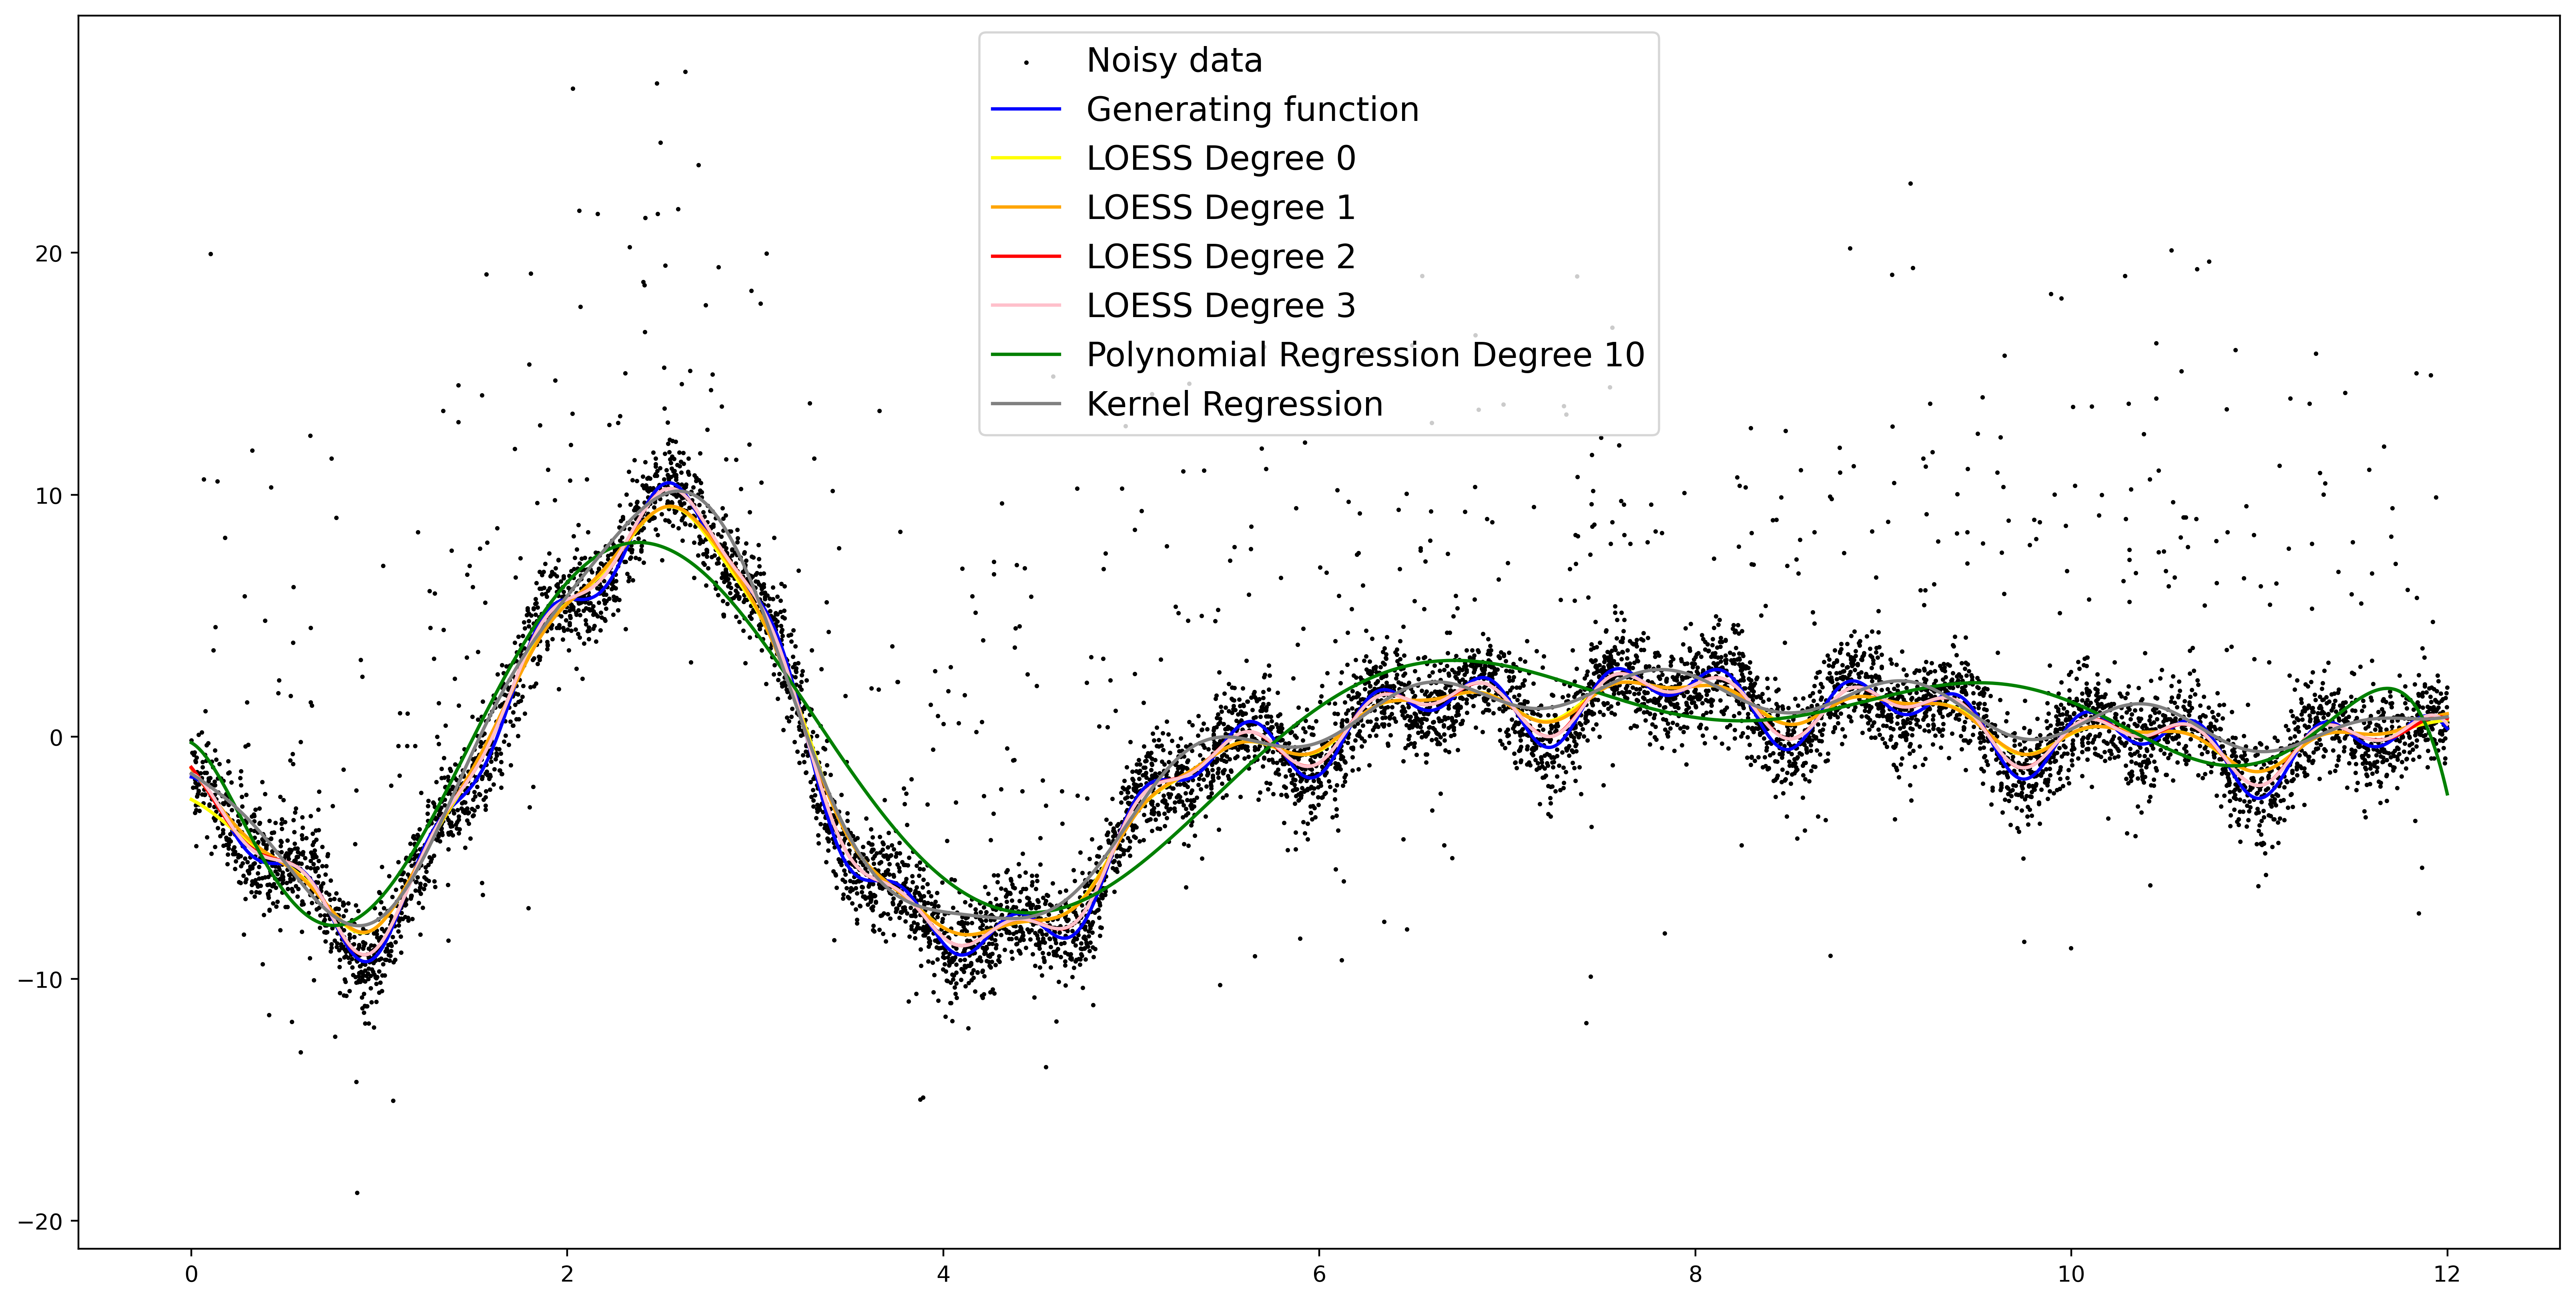

In [10]:
plt.figure(figsize = (20, 10), dpi = 400)
plt.scatter(x, y, s = 1, color = 'black', label = 'Noisy data', alpha = 1)

out = np.hstack((x.reshape(-1, 1), generating.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'blue', label = 'Generating function')

out = np.hstack((x.reshape(-1, 1), y_hat0.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'yellow', label = 'LOESS Degree 0')

out = np.hstack((x.reshape(-1, 1), y_hat1.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'orange', label = 'LOESS Degree 1')

out = np.hstack((x.reshape(-1, 1), y_hat2.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'red', label = 'LOESS Degree 2')

out = np.hstack((x.reshape(-1, 1), y_hat3.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'pink', label = 'LOESS Degree 3')

out = np.hstack((x.reshape(-1, 1), y_hat_poly.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'green', label = 'Polynomial Regression Degree 10')

out = np.hstack((x.reshape(-1, 1), y_hat_kern.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'grey', label = 'Kernel Regression')

plt.legend(fontsize = 15)
plt.show()


In [11]:
( ( generating - y_hat0 ) **2 ).mean()

0.3022308936596188

In [12]:
( ( generating - y_hat1 ) **2 ).mean()

0.2973715388996107

In [13]:
( ( generating - y_hat2 ) **2 ).mean()

0.06089696166806722

In [14]:
( ( generating - y_hat3 ) **2 ).mean()

0.0594216353714314

In [15]:
( ( generating - y_hat_poly ) **2 ).mean()

2.7139639333619723

In [16]:
( ( generating - y_hat_kern ) **2 ).mean()

0.7536154756400194

## Anchored LOESS

In [17]:
num_anchors = int(n / ( x.max() - x.min() ) )
anchors = np.linspace(x.min(), x.max(), num_anchors)

y_hat = fit_loess(x, y, anchors = anchors, degree = 2, kernel = rbf_kernel, alpha = 0.1, frac = None, robust_iters = 3)

In [18]:
y_hat_poly = make_poly_pred_(x.reshape(-1, 1), y, x.reshape(1, -1), weights = np.ones(y.shape[0]), degree = 10)

In [19]:
kern =  KernelRidge(alpha = 0.05, kernel = 'rbf').fit(x.reshape(-1, 1), y)
y_hat_kern = kern.predict(x.reshape(-1, 1))

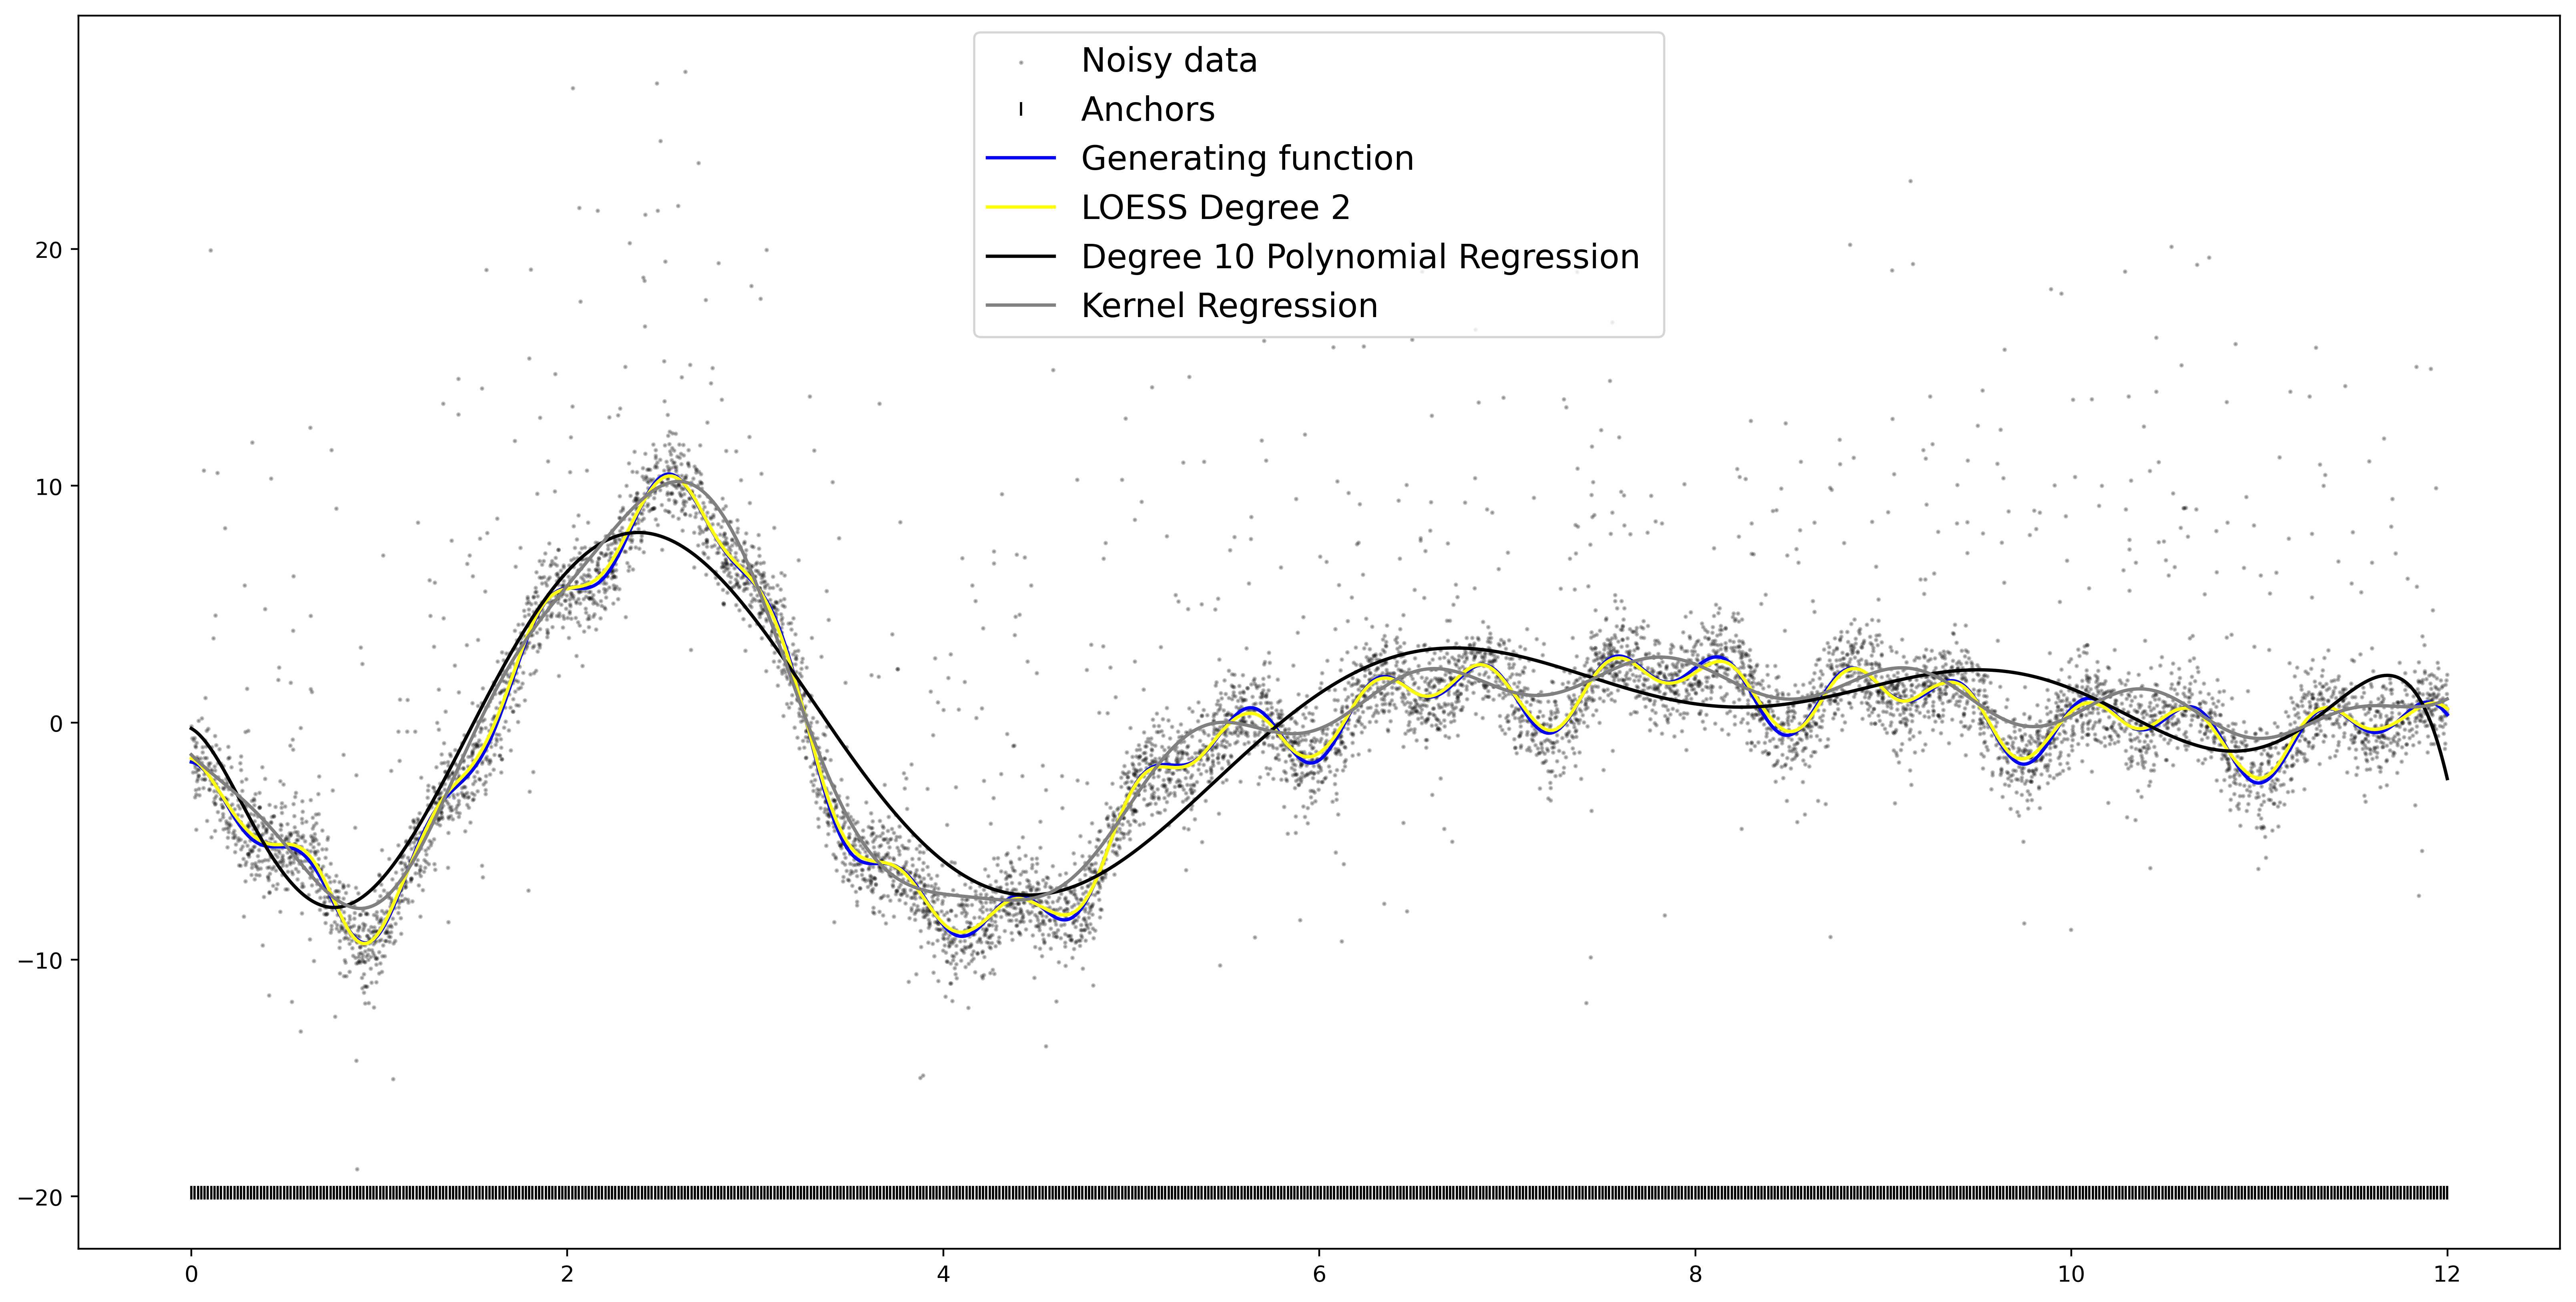

In [20]:
plt.figure(figsize = (20, 10), dpi = 400)

plt.scatter(x, y, s = 1, color = 'black', label = 'Noisy data', alpha = 0.25)

plt.plot(anchors, [y.min() - 1]*len(anchors), '|', color='k', label = 'Anchors')

out = np.hstack((x.reshape(-1, 1), generating.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'blue', label = 'Generating function')

out = np.hstack((x.reshape(-1, 1), y_hat.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'yellow', label = 'LOESS Degree 2')

# out = np.hstack((x.reshape(-1, 1), y_hat_interpolated.reshape(-1, 1)))
# out = out[np.argsort(out[:, 0]), :]
# plt.plot(out[:, 0], out[:, 1], color = 'yellow', label = 'LOESS Degree 2 Interpolated')

out = np.hstack((x.reshape(-1, 1), y_hat_poly.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'black', label = 'Degree 10 Polynomial Regression ')

out = np.hstack((x.reshape(-1, 1), y_hat_kern.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'grey', label = 'Kernel Regression')

plt.legend(fontsize = 15)
plt.show()

In [21]:
( ( generating - y_hat ) **2 ).mean()

0.014499643040682072

In [22]:
( ( generating - y_hat_poly ) **2 ).mean()

2.7139639333619723

In [23]:
( ( generating - y_hat_kern ) **2 ).mean()

0.7476184527197476

## Approximate nearest neighbours LOESS

In [24]:
t0 = time.time()
y_hat = fit_loess(x, y, anchors = None, degree = 2, kernel = rbf_kernel, alpha = 0.1, frac = None, robust_iters = 3)
t1 = time.time() - t0

In [25]:
t1

17.34682297706604

In [26]:
n_clusters = 5
t00 = time.time()
kmeans = KMeans(n_clusters).fit(x.reshape(-1, 1))
t11_cluster = time.time() - t00
labels = kmeans.labels_
y_hat_cluster = np.zeros(x.shape[0])
for i in range(n_clusters):
    cluster_idcs = labels == i
    cluster_x = x[cluster_idcs]
    cluster_y = y[cluster_idcs]
    y_hat_cluster[cluster_idcs] = fit_loess(cluster_x, cluster_y, anchors = None, degree = 2, kernel = rbf_kernel, alpha = 0.1, frac = None, robust_iters = 3)
t11 = time.time() - t00

In [27]:
t11_cluster

0.10136175155639648

In [28]:
t11

18.18078875541687

In [31]:
t000 = time.time()
y_hat_poly = make_poly_pred_(x.reshape(-1, 1), y, x.reshape(1, -1), weights = np.ones(y.shape[0]), degree = 10)
t111 = time.time() - t000

In [32]:
t111

0.004720449447631836

In [33]:
t0000 = time.time()
kern =  KernelRidge(alpha = 0.05, kernel = 'rbf').fit(x.reshape(-1, 1), y)
y_hat_kern = kern.predict(x.reshape(-1, 1))
t1111 = time.time() - t0000

In [34]:
t1111

4.196595668792725

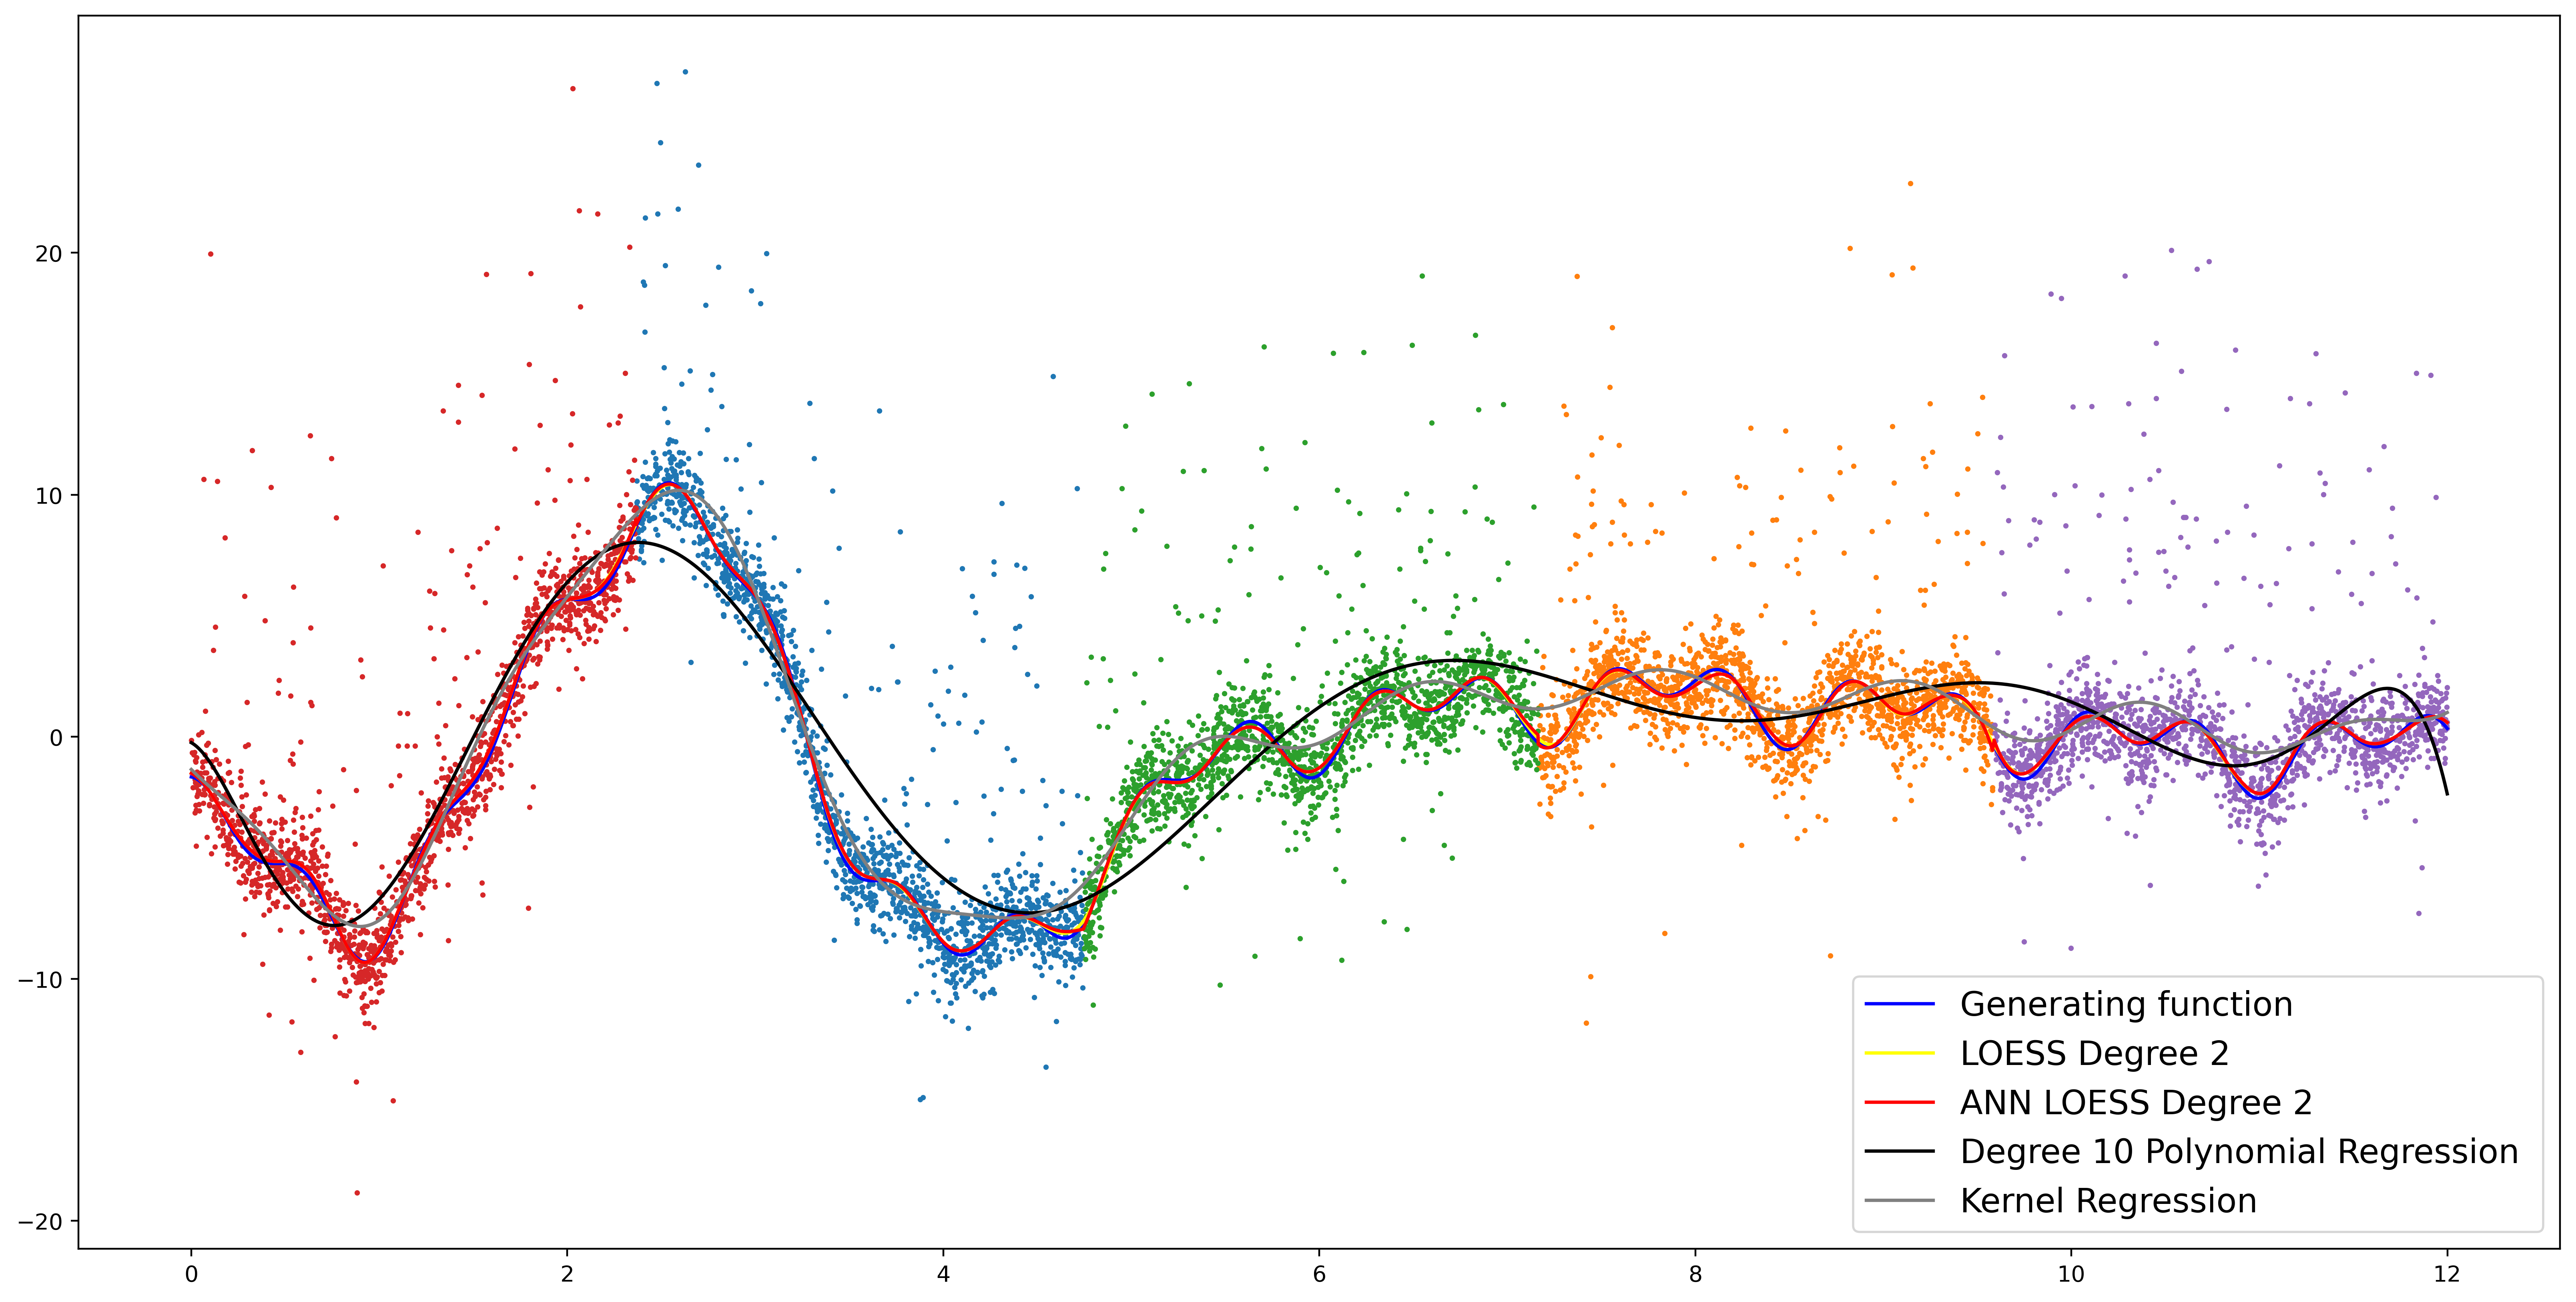

In [35]:
plt.figure(figsize = (20, 10), dpi = 400)
for i in range(n_clusters):
    cluster_idcs = labels == i
    plt.scatter(x[cluster_idcs], y[cluster_idcs], s = 2, alpha = 1)#, label = f'Cluster {i+1}'

out = np.hstack((x.reshape(-1, 1), generating.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'blue', label = 'Generating function')

out = np.hstack((x.reshape(-1, 1), y_hat.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'yellow', label = 'LOESS Degree 2')

out = np.hstack((x.reshape(-1, 1), y_hat_cluster.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'red', label = 'ANN LOESS Degree 2')

out = np.hstack((x.reshape(-1, 1), y_hat_poly.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'black', label = 'Degree 10 Polynomial Regression ')

out = np.hstack((x.reshape(-1, 1), y_hat_kern.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'grey', label = 'Kernel Regression')

plt.legend(fontsize = 15)
plt.show()

In [48]:
( ( generating - y_hat ) **2 ).mean()

0.014292916611517957

In [49]:
( ( generating - y_hat_cluster ) **2 ).mean()

0.015188038839611125

In [50]:
( ( generating - y_hat_poly ) **2 ).mean()

2.7139639333619723

In [51]:
( ( generating - y_hat_kern ) **2 ).mean()

0.7476184527197476

## Sketching approaches

### Randomised subsampled Hadamard transform

In [76]:
# Hadamard transform
H = hadamard(n)

# Subsample matrix with E[number of rows] = n*p
r = 0.1
p = np.random.binomial(size = H.shape[0], n = 1, p = r)
p = np.where(p == 1)[0]

# Random diagonal matrix
d = np.random.binomial(size = H.shape[0], n = 1, p = 0.5)
d[d == 0] = -1

# Randomised Hadamard Transform
HD = H * d

# Sketch matrix
S_had = HD[p, :]

### IID Gaussian random projection

In [77]:
S_gauss = np.random.normal(0, 1, (n, n))[p, :]

### Leverage-based sampling

In [89]:
m = int(n * r)
d = np.zeros(m) 

x_ = x.reshape(-1, 1)
L = x_ @ np.linalg.inv(x_.T @ x_) @ x_.T
l = np.diag(L)

p_lev = np.zeros(m, dtype = np.int64)
for i in tqdm(range(m)):
    ix = np.random.choice(list(range(l.shape[0])), p = l)
    p_lev[i] = ix
    d[i] = 1 / np.sqrt(m * l[ix])
    
x_lev = x[p_lev]
y_lev = y[p_lev]
lev_dists = cdist(x_lev.reshape(-1, 1), x_lev.reshape(-1, 1), 'euclidean')

  0%|          | 0/819 [00:00<?, ?it/s]

### Do the sketch

In [79]:
# Sketched Hadamard data
x_sketch_had = S_had @ x
y_sketch_had = S_had @ y

x_sketch_gauss = S_gauss @ x
y_sketch_gauss = S_gauss @ y

In [83]:
# Get the original x's and y's that correspond to the samples taken via the sketch
x_sub = x[p]
y_sub = y[p]
sub_dists = cdist(x_sub.reshape(-1, 1), x_sub.reshape(-1, 1), 'euclidean')

### Whitening transform

In [81]:
def whiten(X, jitter = 0):
    # Compute covariance matrix
    Xcov = np.dot(X.T,X)

    # Eigendvalue decomposition of the covariance matrix
    d, V = np.linalg.eigh(Xcov)

    # Jitter can be add so that eigenvectors associated with
    # small eigenvalues do not get overamplified.
    D = np.diag(1. / np.sqrt(d + jitter))

    # Whitening transformation matrix
    W = np.dot(np.dot(V, D), V.T)

    # Transform the data
    X_white = np.dot(X, W)

    return X_white, W

x_whiten, W = whiten(x.reshape(-1, 1))
y_whiten = np.dot(y.reshape(-1, 1), W)
x_whiten = x_whiten.reshape(-1)[p]
y_whiten = y_whiten.reshape(-1)[p]

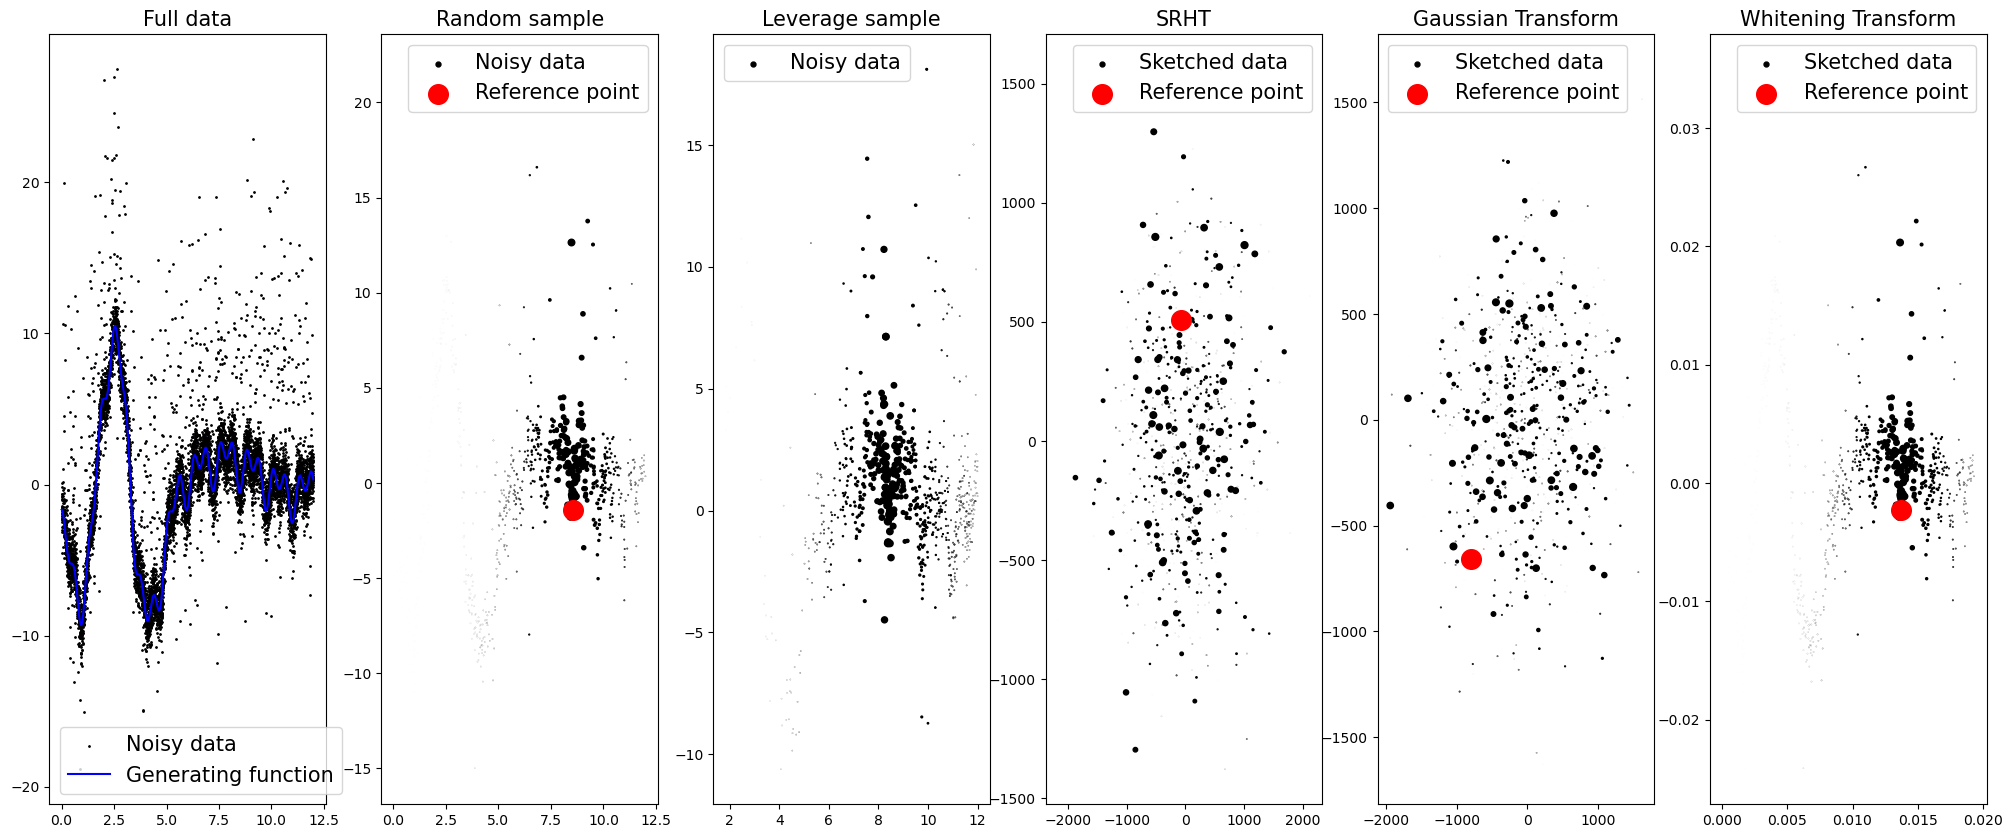

In [92]:
out = np.hstack((x.reshape(-1, 1), generating.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]

fig, ax = plt.subplots(1, 6, figsize = (25, 10))

ax[0].scatter(x, y, s = 1, color = 'black', label = 'Noisy data', alpha = 1)
ax[0].plot(out[:, 0], out[:, 1], color = 'blue', label = 'Generating function')
ax[0].legend(fontsize = 15)
ax[0].set_title('Full data', fontsize = 15)

ax[1].scatter(x_sub, y_sub, s = 25*np.exp(-2*sub_dists[-1, :]), color = 'black', label = 'Noisy data', alpha = 1)
ax[1].scatter(x_sub[-1], y_sub[-1], s = 200, color = 'red', label = 'Reference point')
ax[1].legend(fontsize = 15)
ax[1].set_title('Random sample', fontsize = 15)

ax[2].scatter(x_lev, y_lev, s = 25*np.exp(-2*lev_dists[-1, :]), color = 'black', label = 'Noisy data', alpha = 1)
#ax[2].scatter(x_lev[-1], y_lev[-1], s = 200, color = 'red', label = 'Reference point')
ax[2].legend(fontsize = 15)
ax[2].set_title('Leverage sample', fontsize = 15)

ax[3].scatter(x_sketch_had, y_sketch_had, s = 25*np.exp(-2*sub_dists[-1, :]), color = 'black', label = 'Sketched data', alpha = 1)
ax[3].scatter(x_sketch_had[-1], y_sketch_had[-1], s = 200, color = 'red', label = 'Reference point')
ax[3].legend(fontsize = 15)
ax[3].set_title('SRHT', fontsize = 15)

ax[4].scatter(x_sketch_gauss, y_sketch_gauss, s = 25*np.exp(-2*sub_dists[-1, :]), color = 'black', label = 'Sketched data', alpha = 1)
ax[4].scatter(x_sketch_gauss[-1], y_sketch_gauss[-1], s = 200, color = 'red', label = 'Reference point')
ax[4].legend(fontsize = 15)
ax[4].set_title('Gaussian Transform', fontsize = 15)

ax[5].scatter(x_whiten, y_whiten, s = 25*np.exp(-2*sub_dists[-1, :]), color = 'black', label = 'Sketched data', alpha = 1)
ax[5].scatter(x_whiten[-1], y_whiten[-1], s = 200, color = 'red', label = 'Reference point')
ax[5].legend(fontsize = 15)
ax[5].set_title('Whitening Transform', fontsize = 15)

plt.show()

# Generate two-dimensional synthetic data

In [121]:
n = 2**12

x = np.random.rand(n, 2)

def f(x, y):
    return np.cos( 2 * np.pi * x ) * ( 1 - 3*np.sin(y) )

eps = np.random.normal(0, 0.1, n)
z = f(x[:, 0], x[:, 1]) + eps

m = np.arange(0, 1, 0.05)
anchor_x, anchor_y = np.meshgrid(m, m)
anchors = np.array([np.ravel(anchor_x), np.ravel(anchor_y)]).T

z_hat = fit_loess(x, z, anchors = anchors, degree = 2, kernel = rbf_kernel, alpha = 1, frac = 0.15, robust_iters = 1)
z_hat = z_hat.reshape(anchor_x.shape)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

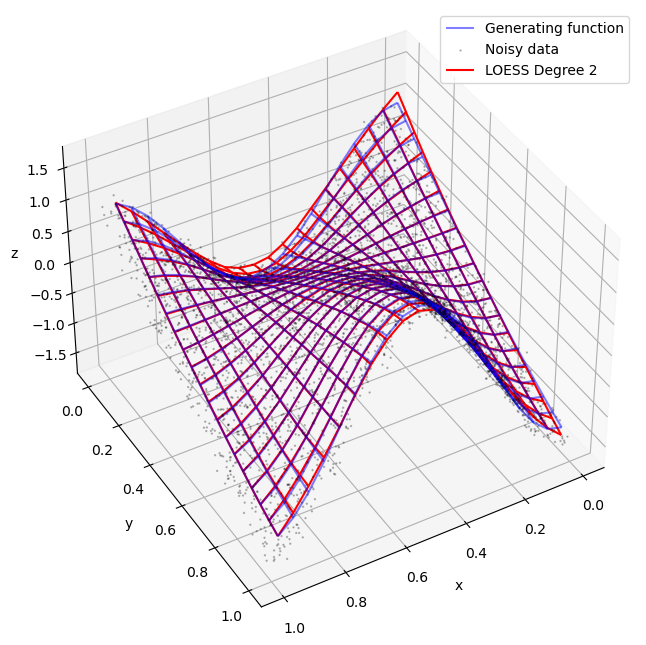

In [52]:
fig = plt.figure(figsize = (25, 8))
ax = fig.add_subplot(111, projection = '3d')

generating = f(anchor_x, anchor_y)
generating = generating.reshape(anchor_x.shape)
ax.plot_wireframe(anchor_x, anchor_y, generating, rcount = 20, ccount = 20, color = 'blue', label = 'Generating function', alpha = 0.5)
ax.scatter(x[:,0], x[:,1], y, '.', color = 'black', alpha = 0.25, label = 'Noisy data', s = 0.5)
ax.plot_wireframe(anchor_x, anchor_y, y_hat, rcount = 20, ccount = 20, color = 'red', label = 'LOESS Degree 2')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.legend()

ax.view_init(40, 60)

In [53]:
X = S @ x
Y = S @ y

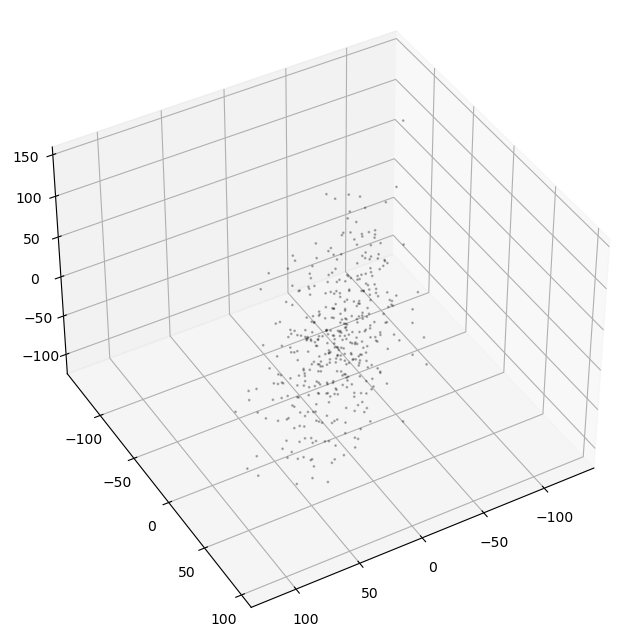

In [54]:
fig = plt.figure(figsize = (25, 8))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(X[:,0], X[:,1], Y, '.', color = 'black', alpha = 0.25, label = 'Noisy data', s = 1)
ax.view_init(40, 60)